## Mini Training for using Accumulated Local Effects (ALE) Plots in R

Accumulated local effects describe **how features influence the prediction of a machine learning model on average**. 

ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

**Motivation:** If features of a machine learning model are correlated, the partial dependence plot cannot be trusted.

ALE plots solve this problem by calculating – also **based on the conditional distribution** of the features – differences in predictions instead of averages

##### Load required packages

In [35]:
library(iml)
library(randomForest)
library(ggplot2)
library(ALEPlot)
library(corrplot)
library(RColorBrewer)

##### Load and prepare data sets

We use the 'Car Insurance Cold Calls' data set from Kaggle (https://www.kaggle.com/kondla/carinsurance), which has already been splitted into training and validation data sets.

In [14]:
X_train = read.csv("X_train.csv", header = T, sep = ",")
X_valid = read.csv("X_valid.csv", header = T, sep = ",")
y_train = read.csv("y_train.csv", header = F, sep = ",")
y_valid = read.csv("y_valid.csv", header = F, sep = ",")

In [15]:
colnames(y_train) = colnames(y_valid) = c("Id","CarInsurance")

In [16]:
train = cbind(X_train, y_train$CarInsurance)
colnames(train)[36] = "CarInsurance"
train = train[,-1]

In [17]:
train$CarInsurance <- as.factor(as.character(train$CarInsurance))

#### Correlations in the data

As the occurance of correlations in the data makes a difference for the applied methods, we want to have a look at them first.

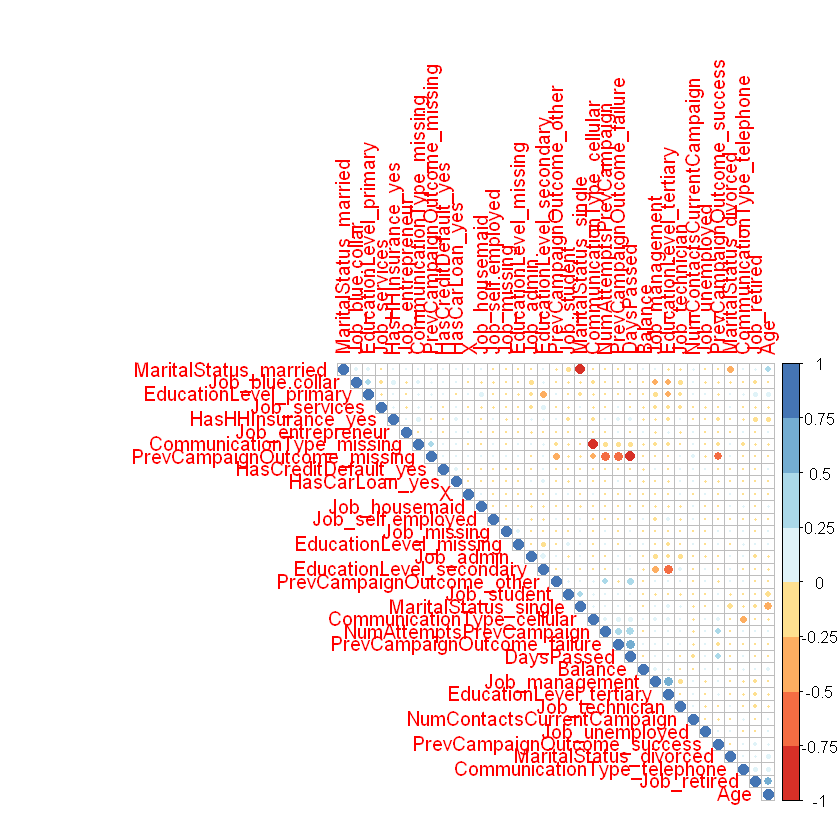

In [36]:
M <-cor(X_train)
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

We want to have a closer look at the correlations of the features 'Age' and 'Balance' as we will look at their ALE and PDP Plots below.

For 'Age', we see a stronger positive correlation (between 0.5 and 0.75) to 'Job_retired', as people are more likely to retire with a higher age. In addition, age is correlated to the marital status: We see a negative correlation between 'Age' and 'MartialStatus_single' and a positive correlation between 'Age' and 'MaritalStatus_married', which both makes sense as older people are more likely to be in a relationship or married. 

For 'Balance', no noteworthy correlations can be seen.

Due to these insights, we expect the ALE and Partial Dependence Plot to be quite similar for the 'Balance' feature. As we have seen correlations between age and other features, differences in the ALE Plot and PDP may occur, as ALE Plots are reflecting these correlations whereas PDP do not.

##### Train a Random Forest Model

In [18]:
rf = randomForest(CarInsurance ~ ., data = train, ntree = 100)

##### Prepare data for iml and create 'predictor'

In [37]:
X = train[which(names(train) != "CarInsurance")]

### ALE and PDP using the 'iml'-package

predictor = Predictor$new(rf, data = X, y = train$CarInsurance)

The 'iml' package offers a possibility to **measure how strongly features interact with each other**. The interaction measure regards how much of the variance of $f(x)$ is explained by the interaction.

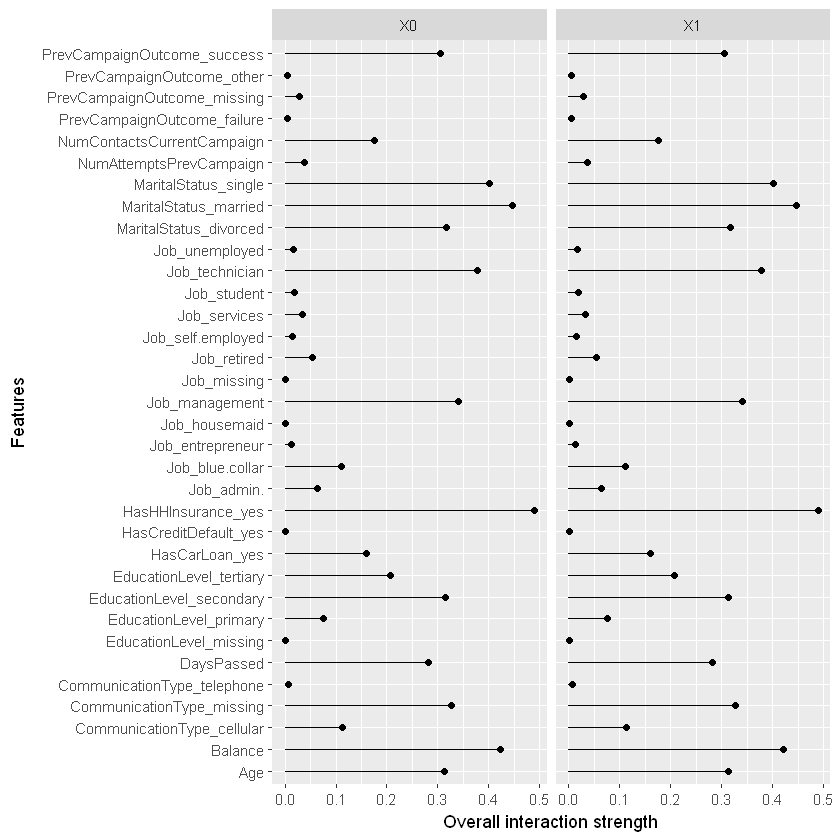

In [40]:
interact = Interaction$new(predictor)
plot(interact)

Here, for 'Balance' the overall interaction strength seems to by higher than expected after just looking at all pairwise correlaions and is even higher than for 'Age'. Altogether interactions seem to play a role for both features.

##### Create ALE and PDP plots for feature 'Age'

Warning message:
"Removed 1 rows containing missing values (geom_path)."

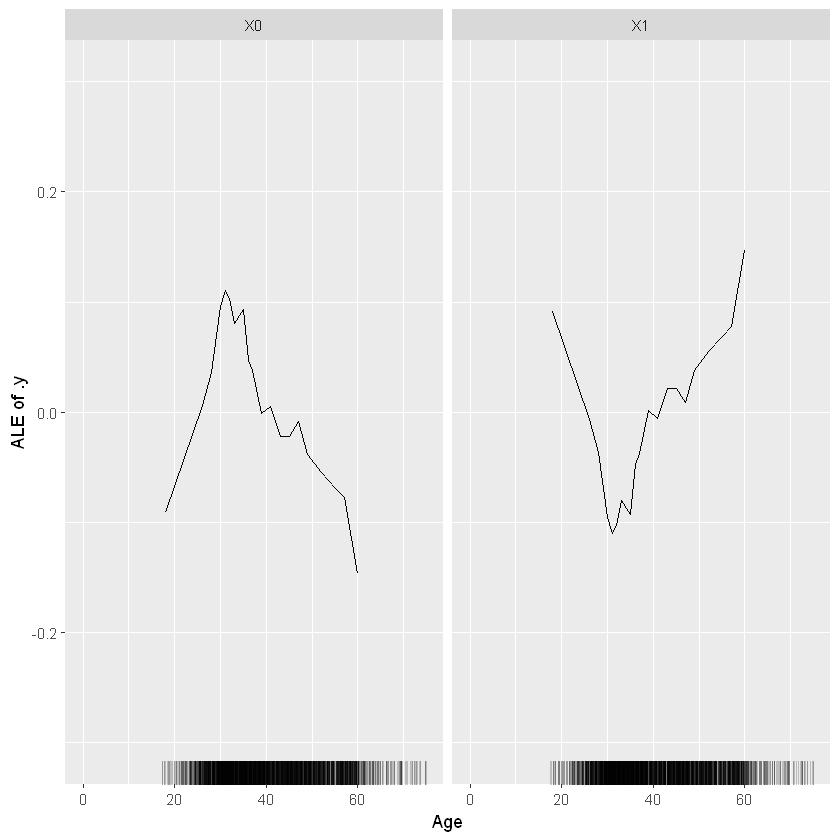

In [22]:
ale = FeatureEffect$new(predictor = predictor, feature = "Age" , method = "ale")

plot(ale) + xlim(0,75)

The ALE plot shows a rather high predicted probability of for buying car insurance for young people at the age of 18-20. The probability then continuosly decreases until it reaches it minimum at the age of 30. From then on, the probability increases almost constantly until the age of 60, where people seem to be most likely to buy car insurance.

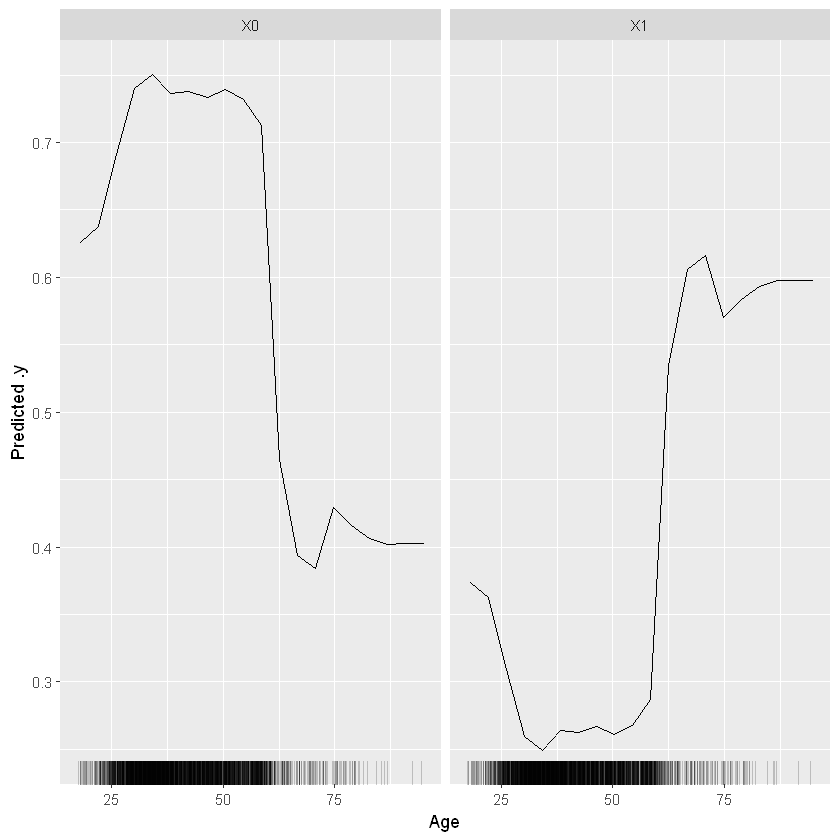

In [23]:
pdp = FeatureEffect$new(predictor = predictor, feature = "Age" , method = "pdp")
plot(pdp)

The Partial Dependence Plot shows a shightly. different effect. Here, the predicted probability also decreases from the age of 20 to the age of 30, but then only slightly increases until the age of 55. Then, a massive increase happens until the age of 60, which by far shows the highest probability of buying car insurance. Then, it slightly decreases again.

Considering interactions by using ALE Plots instead of PD Plots indicate that the effect of the age on the predicted probability of buying car insurance rather constantly increases between the ages of 30 and 60 and does not show such a sudden strong increase as the PDP show.

##### Create ALE and PDP plots for feature 'Balance'

Warning message:
"Removed 3 rows containing missing values (geom_path)."

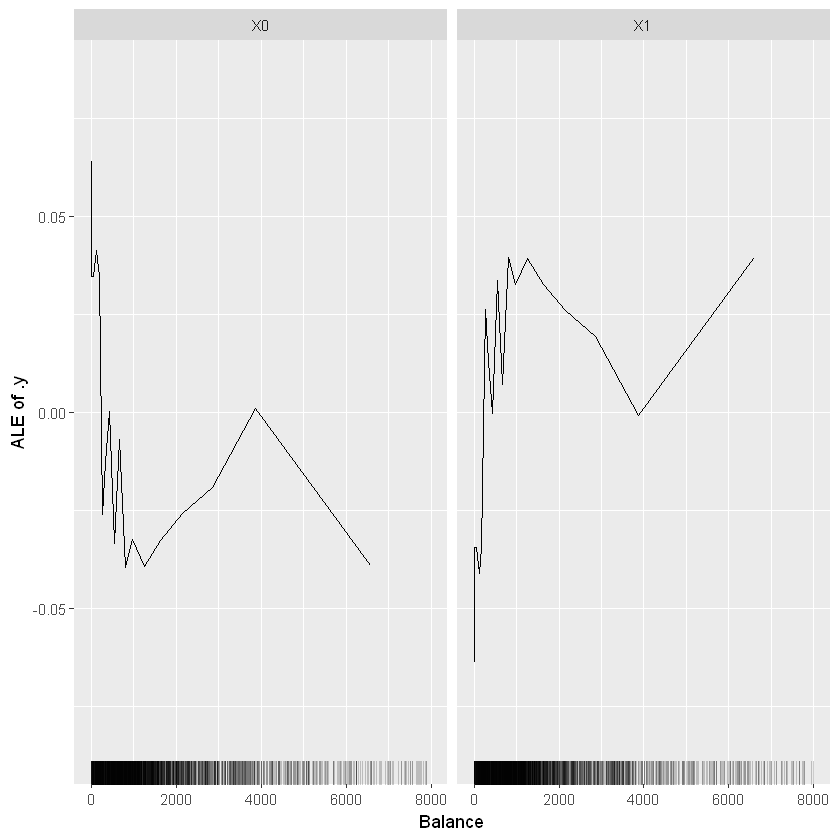

In [24]:
ale = FeatureEffect$new(predictor = predictor, feature = "Balance" , method = "ale")
plot(ale) + scale_x_continuous(limits=c(0,8000))

Warning message:
"Removed 18 rows containing missing values (geom_path)."

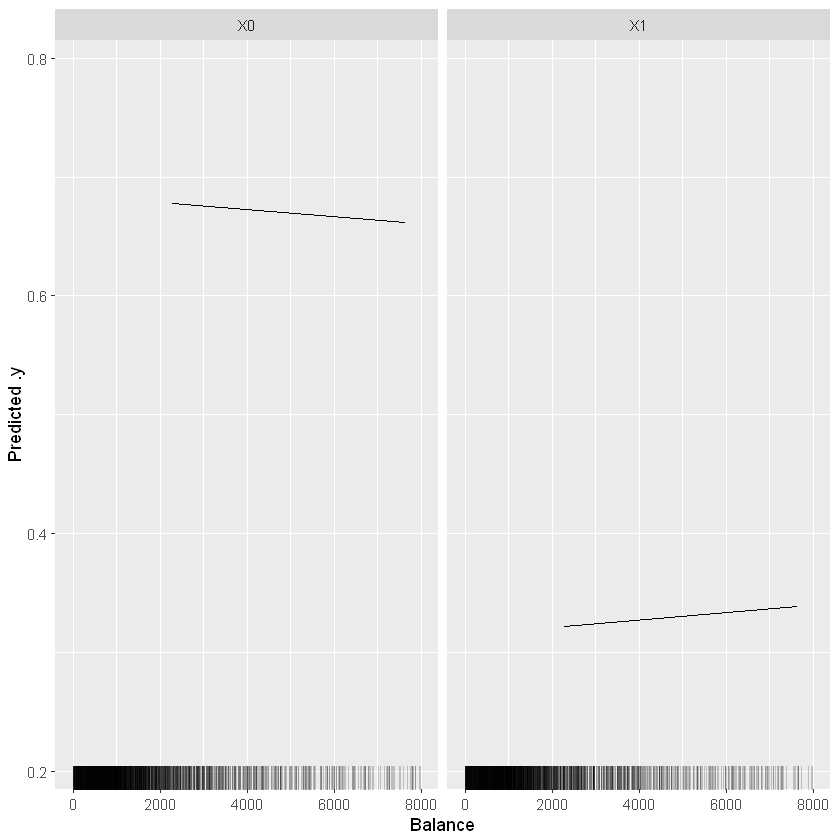

In [25]:
pdp = FeatureEffect$new(predictor = predictor, feature = "Balance" , method = "pdp")
plot(pdp) + scale_x_continuous(limits=c(0,8000))

### ALE and PDP Plots using the 'ALEPlot' package

#### Create a prediction function

In [27]:
yhat <- function(X.model, newdata) as.numeric(predict(X.model, newdata))

#### Create ALE and PDP plots for feature 'Age'

$K
[1] 38

$x.values
 [1] 18 23 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
[26] 49 50 51 52 53 54 55 56 57 58 60 62 70 95

$f.values
 [1]  0.035620130  0.035620130 -0.012766967 -0.061947294 -0.061947294
 [6] -0.106391739 -0.133177453 -0.147883336 -0.133494846 -0.095033308
[11] -0.111562233 -0.111562233 -0.084289506 -0.074485585 -0.041876889
[16] -0.019149616 -0.045465406 -0.031179691 -0.016473809  0.008842647
[21]  0.008842647  0.008842647  0.022000541  0.022000541  0.022000541
[26]  0.075333875  0.075333875  0.106103105  0.121976121  0.139833264
[31]  0.139833264  0.163089078  0.163089078  0.147216062  0.147216062
[36]  0.216983504  0.346015762  0.376784993  0.321229437

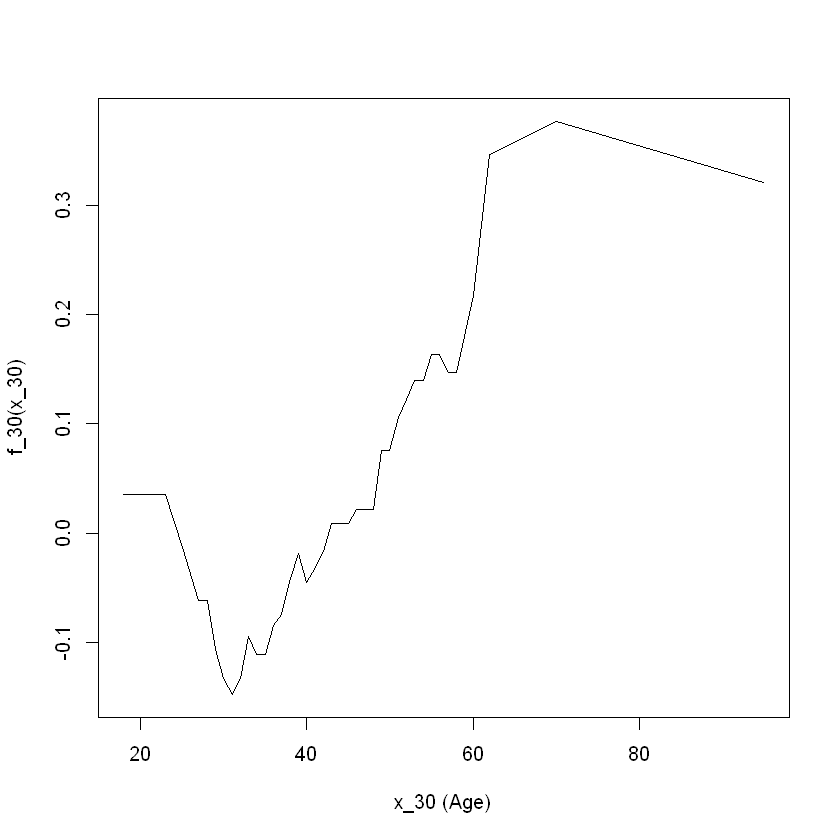

In [28]:
ALEPlot(X, rf, yhat, J=30, K=50, NA.plot = TRUE)

$x.values
 [1] 18.00000 19.57143 21.14286 22.71429 24.28571 25.85714 27.42857 29.00000
 [9] 30.57143 32.14286 33.71429 35.28571 36.85714 38.42857 40.00000 41.57143
[17] 43.14286 44.71429 46.28571 47.85714 49.42857 51.00000 52.57143 54.14286
[25] 55.71429 57.28571 58.85714 60.42857 62.00000 63.57143 65.14286 66.71429
[33] 68.28571 69.85714 71.42857 73.00000 74.57143 76.14286 77.71429 79.28571
[41] 80.85714 82.42857 84.00000 85.57143 87.14286 88.71429 90.28571 91.85714
[49] 93.42857 95.00000

$f.values
 [1]  0.088320556  0.084320556  0.081987222  0.078987222  0.065653889
 [6]  0.026320556  0.021320556 -0.010012778 -0.027679444 -0.025346111
[11] -0.033346111 -0.039346111 -0.026346111 -0.020012778 -0.025346111
[16] -0.022012778 -0.016012778 -0.018346111 -0.018346111 -0.028346111
[21] -0.022012778 -0.017346111 -0.015012778 -0.015679444 -0.015346111
[26] -0.013346111  0.001987222  0.026987222  0.237987222  0.264653889
[31]  0.284653889  0.324653889  0.327320556  0.322653889  0.329320556
[36]  0.317653889  0.287653889  0.289320556  0.293653889  0.315987222
[41]  0.315653889  0.309320556  0.312320556  0.313320556  0.312987222
[46]  0.311987222  0.312987222  0.314653889  0.311320556  0.312653889

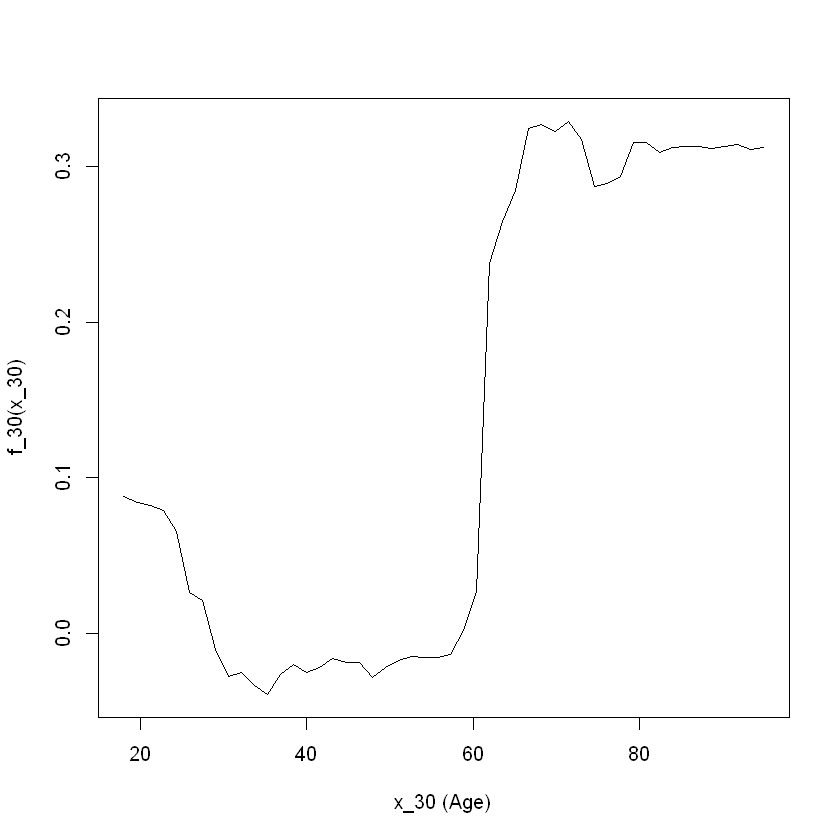

In [29]:
PDPlot(X, rf, yhat, J=30, K=50)

#### Create ALE and PDP plots for feature 'Balance'

$K
[1] 48

$x.values
 [1] -3058  -340  -165   -17     0     1    11    36    53    81   102   132
[13]   157   184   208   242   279   308   345   386   421   458   497   540
[25]   597   647   696   756   814   879   940  1026  1140  1253  1388  1533
[37]  1707  1903  2157  2367  2694  2999  3400  3870  4780  5776  7443 10250
[49] 98417

$f.values
 [1] -0.096096457 -0.179429790 -0.179429790 -0.179429790 -0.166877489
 [6] -0.066877489 -0.066877489 -0.099664374 -0.099664374 -0.099664374
[11] -0.099664374 -0.099664374 -0.116057817 -0.132724484 -0.149965863
[16] -0.002424879  0.014241787  0.031190940 -0.002142394 -0.002142394
[21] -0.019999536  0.013333797  0.013333797  0.030000464  0.013333797
[26]  0.013333797  0.029727240  0.046393906  0.080292211  0.096958878
[31]  0.096958878  0.096958878  0.096958878  0.096958878  0.080565435
[36]  0.097514588  0.097514588  0.097514588  0.080847921  0.064181255
[41]  0.080574697  0.114473002  0.081139669  0.081139669  0.097806336
[46]  0.114473002  0.114473002  0.164473002  0.164473002

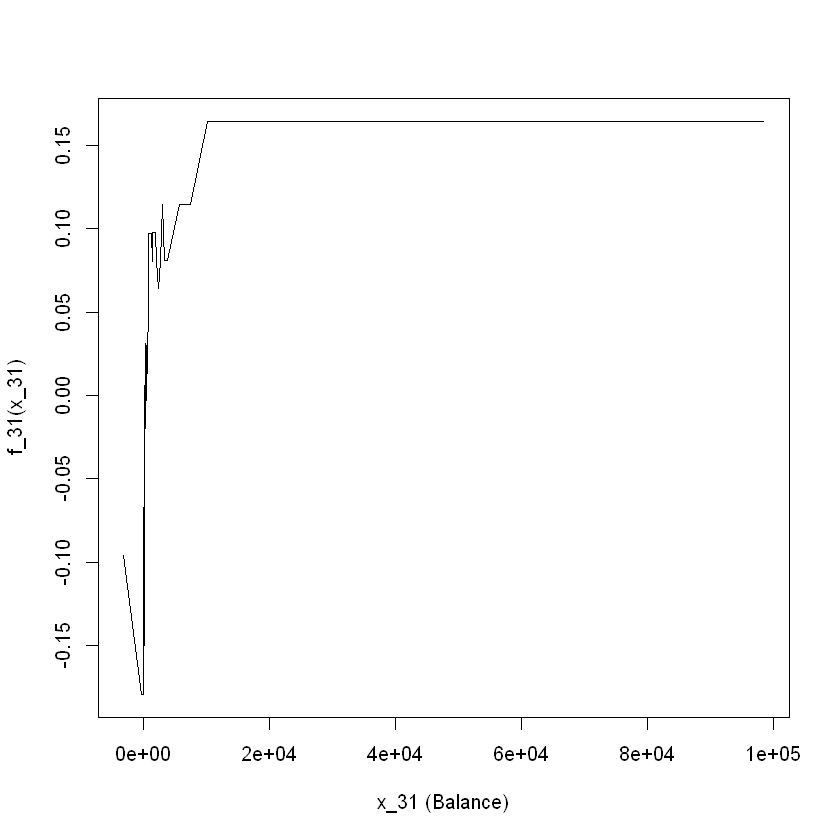

In [38]:
ALEPlot(X, rf, yhat, J=31, K=50, NA.plot = TRUE)

$x.values
 [1] -3058.0000  -987.0816  1083.8367  3154.7551  5225.6735  7296.5918
 [7]  9367.5102 11438.4286 13509.3469 15580.2653 17651.1837 19722.1020
[13] 21793.0204 23863.9388 25934.8571 28005.7755 30076.6939 32147.6122
[19] 34218.5306 36289.4490 38360.3673 40431.2857 42502.2041 44573.1224
[25] 46644.0408 48714.9592 50785.8776 52856.7959 54927.7143 56998.6327
[31] 59069.5510 61140.4694 63211.3878 65282.3061 67353.2245 69424.1429
[37] 71495.0612 73565.9796 75636.8980 77707.8163 79778.7347 81849.6531
[43] 83920.5714 85991.4898 88062.4082 90133.3265 92204.2449 94275.1633
[49] 96346.0816 98417.0000

$f.values
 [1] -0.094284889 -0.098951556 -0.006951556  0.008381778  0.028048444
 [6]  0.030381778  0.019381778  0.018715111  0.016048444  0.003048444
[11]  0.002048444 -0.001618222 -0.005284889 -0.004951556 -0.007951556
[16] -0.006284889 -0.004951556 -0.005951556 -0.002618222 -0.002951556
[21] -0.004951556 -0.003951556 -0.002618222 -0.003284889 -0.002618222
[26] -0.004618222 -0.002618222 -0.002284889 -0.003284889 -0.002951556
[31] -0.002618222 -0.002284889 -0.003618222 -0.002618222 -0.002951556
[36] -0.002951556 -0.004284889 -0.003951556 -0.003951556 -0.003618222
[41] -0.001618222 -0.003284889 -0.001618222 -0.001618222 -0.001618222
[46] -0.003284889 -0.002951556 -0.002284889 -0.003618222 -0.002951556

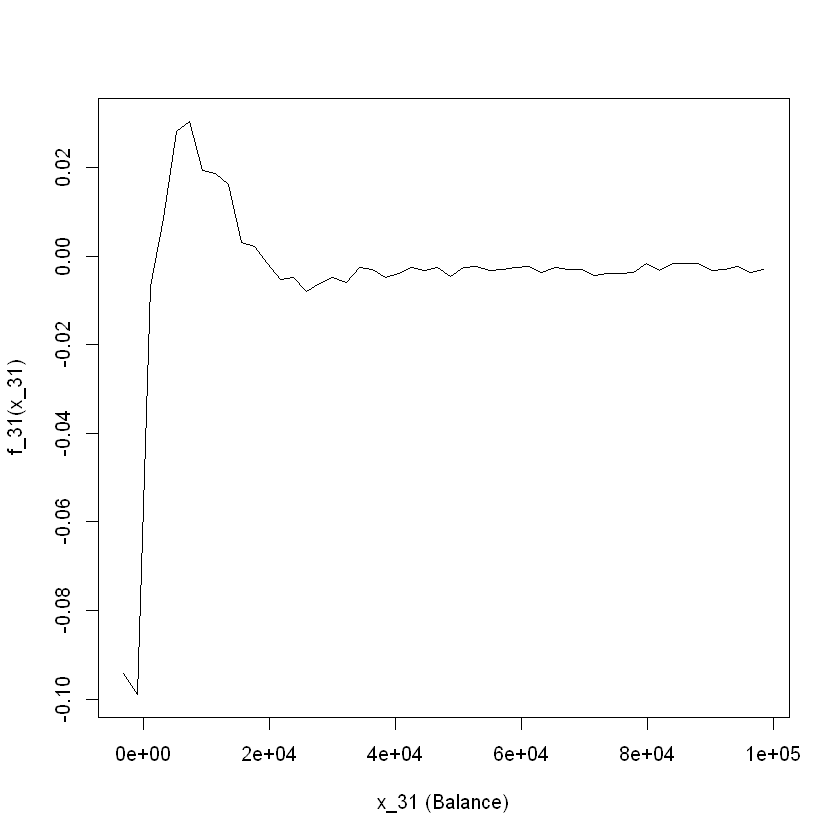

In [39]:
PDPlot(X, rf, yhat, J=31, K=50)